Christiaan van Roon - 11122854  
Sander Hansen - 10995080

# Image Mosaic

In [49]:
#Pylab inline is not a good habit to use
import numpy
import matplotlib
import cv2

from matplotlib import pylab, mlab, pyplot
np = numpy
plt = pyplot

from IPython.core.pylabtools import figsize, getfigs
from skimage.transform import matrix_transform
from skimage.transform import SimilarityTransform
from skimage.filters import gaussian

from pylab import *
from numpy import *

## Projective Transform

The first thing we want to do, is stitch two images together by using a projective transform. This can be done if we find some points which are on both images. We will use the two following images.

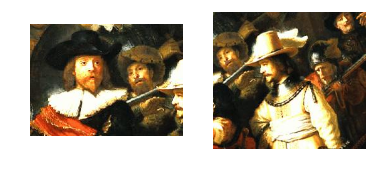

In [2]:
f1 = plt.imread('img/nachtwacht1.jpg')/255
plt.subplot(121); plt.imshow(f1); plt.axis('off');
f2 = plt.imread('img/nachtwacht2.jpg')/255
plt.subplot(122); plt.imshow(f2); plt.axis('off');
plt.show()

### Theory

First we want to achieve that we can stitch two images together with given points. This is not more then a projective transform from one point to another. We used the code of our transform function of week 2.

We can get the right matrix by using the following formula;


$$\begin{split}s\begin{pmatrix}x'\\y'\\1\end{pmatrix} =&
\begin{pmatrix}a & b & c\\d & e & f\\g & h & i\end{pmatrix}
\begin{pmatrix}x\\y\\1\end{pmatrix} \\
\end{split}$$

We can get the parameters by rewriting this formula and stack the x_{i} and y_{i} values in a matrix. By rewriting we also know that the following expression is true;

$$\begin{split}\begin{pmatrix}
x_1 & y_1 & 1 & 0 & 0 & 0 & -x_1'x_1 & -x_1'y_1 & -x_1'\\
0 & 0 & 0 & x_1 & y_1 & 1 & -y_1'x_1 & -y_1'y_1 & -y_1'\\
x_2 & y_2 & 1 & 0 & 0 & 0 & -x_2'x_2 & -x_2'y_2 & -x_2'\\
0 & 0 & 0 & x_2 & y_2 & 1 & -y_2'x_2 & -y_2'y_2 & -y_2'\\
x_3 & y_3 & 1 & 0 & 0 & 0 & -x_3'x_3 & -x_3'y_3 & -x_3'\\
0 & 0 & 0 & x_3 & y_3 & 1 & -y_3'x_3 & -y_3'y_3 & -y_3'\\
x_4 & y_4 & 1 & 0 & 0 & 0 & -x_4'x_4 & -x_4'y_4 & -x_4'\\
0 & 0 & 0 & x_4 & y_4 & 1 & -y_4'x_4 & -y_4'y_4 & -y_4'
\end{pmatrix}
\begin{pmatrix}a\\b\\c\\d\\e\\f\\g\\h\\i \end{pmatrix} =&
\begin{pmatrix}0\\0\\0\\0\\0\\0\\0\\0 \end{pmatrix} \\
\end{split}$$

With the help of the singular value decomposition $UDV^T$ from M we can figure out that the last column of V are the values of p we need.


### Algorithm

It is adjusted a little bit so it can handle more then four points. At first we tested it with the four given points: 

In [3]:
from skimage.transform import warp

# Points need to be given in the following manner: [x, y, newX, newY]
def perspectiveTransformMatrix(points):
    M = np.zeros([2 * points.shape[0],9])
    
    for i in range(points.shape[0]):
            M[i * 2] = points[i][0], points[i][1], 1, 0, 0, 0, -points[i][2] * points[i][0], \
                       -points[i][2] * points[i][1], -points[i][2]
            M[i * 2 + 1] = 0, 0, 0, points[i][0], points[i][1], 1, -points[i][3] * points[i][0], \
                           -points[i][3] * points[i][1], -points[i][3]
       
    _, _, V = np.linalg.svd(M)
    
    p = V[-1]
    A = p.reshape(3, 3)
    
    return A

In [4]:
points = np.array([[157, 32, 6, 38], [211, 37, 56, 31], [222, 107, 82, 87],[147, 124, 22, 118]])

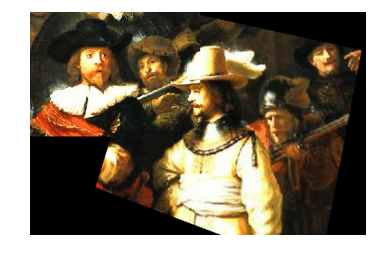

In [5]:
P = perspectiveTransformMatrix(points)
f_stitched = warp(f2, P, output_shape=(300,450))
M, N = f1.shape[:2]
f_stitched[0:M, 0:N, :] = f1
plt.imshow(f_stitched); plt.axis('off')
plt.show()

Then we tested it with more points, we found those manually. Which gave us an equal result.

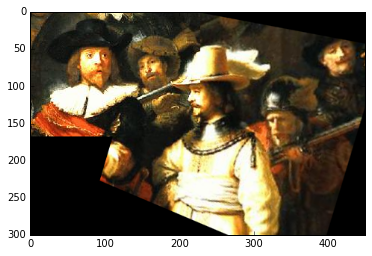

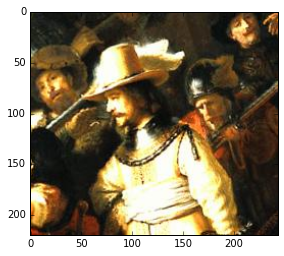

In [21]:
f1 = plt.imread('img/nachtwacht1.jpg')/255
f2 = plt.imread('img/nachtwacht2.jpg')/255

points = np.array([[157, 32, 6, 38], [211, 37, 56, 31], [222, 107, 82, 87],[147, 124, 22, 118], \
                   [210, 120, 76, 98], [150, 75, 11, 75]])

P = perspectiveTransformMatrix(points)
f_stitched = warp(f2, P, output_shape=(300,450))
M, N = f1.shape[:2]
f_stitched[0:M, 0:N, :] = f1
plt.imshow(f_stitched); #plt.axis('off')
plt.show()

plt.imshow(f2)
plt.show()

The last part of the transform is to make sure that everything from both of the images will be in the final image. We can do this by calculating the corner coordinates of the transformed image. Adjust the size and translate the resulting image.

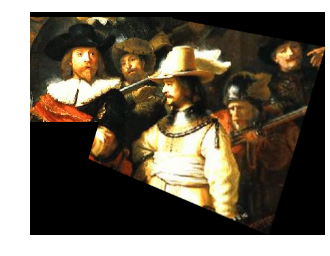

In [41]:
def fit_image(f1, f2, P):
    tx = 0
    ty = 0
    
    xy1 = matrix_transform([0, 0], np.linalg.inv(P))
    xy2 = matrix_transform([0, f2.shape[0]], np.linalg.inv(P))
    xy3 = matrix_transform([f2.shape[1], f2.shape[0]], np.linalg.inv(P))
    xy4 = matrix_transform([f2.shape[1], 0], np.linalg.inv(P))

    x_min = min(xy1[0][0], xy2[0][0], xy3[0][0], xy4[0][0], 0)
    x_max = max(xy1[0][0], xy2[0][0], xy3[0][0], xy4[0][0], f1.shape[1])
    y_min = min(xy1[0][1], xy2[0][1], xy3[0][1], xy4[0][1], 0)
    y_max = max(xy1[0][1], xy2[0][1], xy3[0][1], xy4[0][1], f1.shape[0])

    x = int(x_max - x_min)
    y = int(y_max - y_min)
    
    if y_min < 0:
        ty = y_min
    if x_min < 0:
        tx = x_min 

    f_stitched = warp(f2, P, output_shape=(y,x))
    M, N = f1.shape[:2]
    f_stitched[0:M, 0:N, :] = f1
    tform = SimilarityTransform(translation=(tx, ty))
    warped = warp(f_stitched, tform)
    plt.imshow(warped); plt.axis('off')
    plt.show()

fit_image(f1, f2, P)

## Sift

We will not implement sift at our own so their will not be two seperate sections of the algorithm and theory, we will be dealing with both at the same time. We will use the sift algorithm in this excercise because it's able to detect the same keypoints in two different images. Independent of translation, rotation and scale (so they will not change). 

There are four major steps in the SIFT algorithm;

1. Scale-space extrema detection
2. Keypoint localization
3. Orientation assignment
4. Keypoint descriptor

### Scale-space extrema detection

To find keypoints in the images (points that are distingishable) a Gaussian kernel is used. This for the reason that this kernel is the only scale space kernel. We define the space scale:

$$L(x,y,\sigma) = G(x,y,\sigma)*I(x,y)$$

Where $I(x,y)$ is the input image and $G(x,y,\sigma)$ the two dimensional Gaussian kernel.

To distinguish local extrema two images are substracted from each other. But not just two, the Gaussian is applied on different scales. So the Adjacent Gaussian images are substracted from each other where the Gaussian image is down-sampled by a factor of 2 each time. We can write this down as:

$$D(x,y,\sigma) = L(x,y,k\sigma) - L(x,y,\sigma)$$

where k is the scale factor for the Gaussian function, we call D the Difference-of-Gaussian.

This however, is not scale invariant, therefor it is also applied on the following 'octaves' which are scaled down versions of the image. The maxima can then be detected by comparing a pixel with it's neighbours (the next and previous Difference-of-Gaussians are also his neighbours).

This process is illustrated for the nachtwacht picture below.

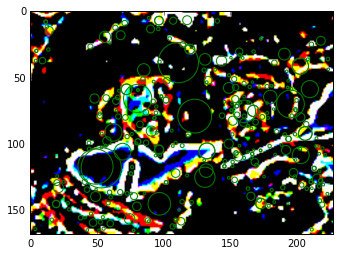

In [60]:
f = plt.imread('img/nachtwacht1.jpg')
fcv2 = f[:,:,::-1] # OpenCV uses BGR ordering of color channels

fg_1 = gaussian(f, multichannel=True)
fg_2 = gaussian(fg_1, multichannel=True)
fg_3 = gaussian(fg_2, multichannel=True)
fg_4 = gaussian(fg_3, multichannel=True)

fg_5 = fg_4 - fg_3

plt.imshow(fg_5);

sift = cv2.xfeatures2d.SIFT_create()
kps, dscs = sift.detectAndCompute(fcv2, mask=None)
ax = plt.gca()
for kp in kps:
    ax.add_artist(plt.Circle((kp.pt), kp.size/2, color='green', fill=False))
plt.show()

### Keypoint localization
The second step is to filter out those points which are actually bad points. (Think of points which are along a straight light which can only be distinguished in 1D or points with low contrast).

To filter out the points with low contrast we will look at the interpolated location is determined. A 3x3 system will come out which can be solved. If the value of this system is larger then 0.5 it means that the extremum can be found closer at another point.

The edges can be removed by calculating the Hessian matrix (which describes the curvature), of whom we will need the Determinant en eigenvalues ($\alpha$ and $\beta$). We can get the formula of $Tr(H) = \alpha + \beta$ Which can then be narrowed down to the following formula:

$$\frac{Tr(H)^2}{Det(H)}<\frac{(r+1)^2}{r}$$

r is the variable which determines the ratio of whom the curvature can differ.

### Orientation assignment

We want an orientation invariant descriptor. To achieve this we first select the Gaussian smoothed image with the closest scale, L. For each image sample at this scale L, the magnitude $m(x,y)$ and orientation $\phi(x,y)$ are computed. 

$$m(x,y) = \sqrt{(L(x+1,y) - L(x-1,y))^2+(L(x,y+1)-L(x,y-1))^2}$$
$$\phi(x,y) = \tan^{-1}((L(x,y+1)-L(x,y-1))/(L(x+1,y) - L(x-1,y)))$$

Of the orientation a histogram is formed of a region around the keypoint with 36 bins covering 360 degrees. Each orientation sample is weighed by it's magnitude. 

### Keypoint Descriptor

To make the descriptor we will sample the magnitude and orientations around the keypoint. We will use the scale to select the right Gaussian blurred function. 

The orientations are cummelated in a oriantatoin histogram which will summarize it in 16 (4x4) subregions. Finally the vectors of the magnitude and orientation are normalized to make them invariant to illumination. The normalisatoin will happen in the dominant direction to make sure they are oriantation invariant as well.

After this all we will use a matcher which will compare the different descriptors and gives us a list of matches.

In [ ]:
f1 = plt.imread('img/nachtwacht1.jpg')
f2 = plt.imread('img/nachtwacht2.jpg')

def return_matches(f1, f2):
    f1cv2 = f1[:,:,::-1] # OpenCV uses BGR ordering of color channels
    f2cv2 = f2[:,:,::-1] # OpenCV uses BGR ordering of color channels

    sift = cv2.xfeatures2d.SIFT_create()

    kps1, dscs1 = sift.detectAndCompute(f1cv2, mask=None)
    kps2, dscs2 = sift.detectAndCompute(f2cv2, mask=None)

    matcher = cv2.BFMatcher()
    matches = matcher.match(dscs1,dscs2)
    
    return matches, kps1, kps2

matches, kps1, kps2 = return_matches(f1, f2)

## Ransac

### Theory

Ransac, Random sample consesus is an algorithm that is not really hard to understand. That's why we will give just a quick overview of how it works. The real process can be found below where we implemented the Ransac algorithm.

The Ransac algorithm is a way to eliminate the wrong matches by trial and error and basicly consist of three steps which will be repeated a given amount of times.

1. First we will contain a random sample of data of which we will assume that is correct. In this situation this will be a few "matches" of points found bij the sift algorithm.  

2. Then we will make a model which is fitted to those randomly selected matches. So we will compute the transformation with those points.

3. At last we will check how many of the other points, which where not in the random set, are fitting in the model. So in our case which are in a reasanoble distance from the place where they should be.

We will keep the configuration of random points which has the most correct points at step three. 

### Algorithm

First we will get an array of x and y values of the matches. This is done in the following manner (according to the encoding of the match type).

In [ ]:
points = np.array([])

for m in matches:
     points = np.append(points, 
                        [kps1[m.queryIdx].pt[0], kps1[m.queryIdx].pt[1], \
                        kps2[m.trainIdx].pt[0], kps2[m.trainIdx].pt[1]])

points = points.reshape(((int(points.shape[0] / 4), 4)))

There are a few variables we need to configure:

n – the minimum number of data values required to fit the model 

k – the maximum number of iterations allowed in the algorithm

t – a threshold value for determining when a data point fits a model

d – the number of close data values required to assert that a model fits well to data

In [ ]:
n = 4
k = 1000
t = 5
d = 10

Then we can start with programming the actual algorithm. First we need to create a sample data set of what we will call hypothetical inliers.

In [ ]:
def get_random(points, n):
    ind = np.arange(points.shape[0])
    np.random.shuffle(ind)

    h_inliers = ind[:n]
    h_model = ind[n:]

    return points[h_inliers], points[h_model]

In [ ]:
def get_error(P, h_inliers, h_model, b_error, b_model):
    inliers = np.array([])

    for i in h_model:
        new_pos = matrix_transform([i[0], i[1]], P)
        error = np.linalg.norm([i[2], i[3]] - new_pos)

        if error < t:
            inliers = np.append(inliers, i)

    if (inliers.shape[0] / 4) > d:
        inliers = np.append(inliers, h_inliers)
        inliers = inliers.reshape(((int(inliers.shape[0] / 4), 4)))
        P2 = perspectiveTransformMatrix(inliers)

        for i in h_model:
            new_pos = matrix_transform([i[0], i[1]], P)
            error += np.linalg.norm([i[2], i[3]] - new_pos)
            error = error / inliers.shape[0]

        if error < b_error:
            b_error = error
            b_model =  P2
    
    return b_model, b_error

In [ ]:
def ransac(points, n, k, t, d):
    b_error = 1000000000
    b_model = 0

    for _ in range(k):
        h_inliers, h_model = get_random(points, n)
        P = perspectiveTransformMatrix(h_inliers)
        b_model, b_error = get_error(P, h_inliers, h_model, b_error, b_model)
    
    return b_model

This all can then be runned by using the ransac function. 

However, there seems to be a problem with this notebook which will not give us the correct output. But if we put all of the code above in a normal python file, it will run correctly. Therefor we included the images of the results below. The code we used to run this is the same code as above plus a call to the ransac function and the stichting of the image. We also included this code if you want to run this for yourself (stitching.py). For the simple reason that we documented everything here, this code is not organised and just does the job.

So in summary this code will first,

1. Run the sift algorithm
2. Run the ransac with the help of perspectiveTransform
3. Stitch the images together the same way we did before

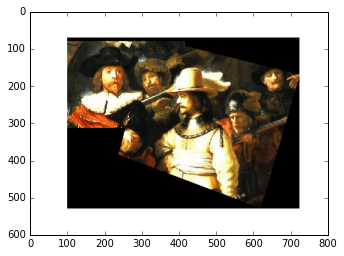

In [43]:
stitched_nachtwacht = plt.imread('img/stitched_nachtwacht.png')
plt.imshow(stitched_nachtwacht)
plt.show()

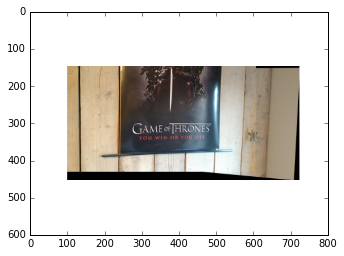

In [45]:
stitched_room = plt.imread('img/stitched_room.png')
plt.imshow(stitched_room)
plt.show()

## Conclusions

The sift algortihm in combination with Ransack works great for stitching images together. The lower threshold we use and the more itterations the better. But it's already good enough at a threshold of 5 with 400 to 500 itterations.